<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/WISDM_LSTM_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# -----------------------------------------
# 0) 데이터 로드 & 1차 전처리
# -----------------------------------------
path = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', 'NaN']
raw = pd.read_csv(
    path,
    header=None,
    names=names,
    comment=';',
    engine='python',
    on_bad_lines='skip'
)

# 문자열 → 숫자
for c in ['X', 'Y', 'Z']:
    raw[c] = raw[c].astype(str).str.strip().str.rstrip(';')
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

# 결측/불필요 제거
df = raw.drop(columns=['NaN']).dropna(subset=['X','Y','Z'])

# 물리적인 이상치는 클리핑
for c in ['X','Y','Z']:
    df[c] = df[c].clip(lower=-20.0, upper=20.0)

# subject별 표준화
def subject_standardize(g):
    for c in ['X','Y','Z']:
        m = g[c].mean()
        s = g[c].std()
        if s == 0 or np.isnan(s):  # 분산 0 방지
            s = 1.0
        g[c] = (g[c] - m) / s
    return g

df = df.groupby('user-id', group_keys=False).apply(subject_standardize)

# magnitude 파생
df['mag'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)

# 시간순 정렬
df = df.sort_values(['user-id','timestamp']).reset_index(drop=True)

# 라벨 인코딩
classes = sorted(df['activity'].unique().tolist())
cls2id = {c:i for i,c in enumerate(classes)}
id2cls = {i:c for c,i in cls2id.items()}
df['label'] = df['activity'].map(cls2id).astype(int)

print("활동 클래스:", classes)
print("유저 수:", df['user-id'].nunique())

/tmp/ipython-input-2308181054.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('user-id', group_keys=False).apply(subject_standardize)


활동 클래스: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
유저 수: 36


In [2]:
# 1) 세그먼트 만들기 (정적 윈도우 제거를 좀 더 세게)
# -----------------------------------------
def make_segments(df_in, time_steps=80, step=None, min_var=5e-4):
    if step is None:
        step = time_steps
    feats_list, labels, sids = [], [], []
    FEATS = ['X','Y','Z','mag']

    for (uid, act), g in df_in.groupby(['user-id','activity'], sort=False):
        arr = g[FEATS + ['label']].to_numpy()
        L = len(arr)
        if L < time_steps:
            continue
        for st in range(0, L - time_steps + 1, step):
            win = arr[st:st+time_steps]         # (T,5)
            xwin = win[:, :-1].astype(np.float32)  # (T,4)
            lab_win = win[:, -1].astype(int)

            # 너무 변화 없는 구간 제거
            if xwin.var() < min_var:
                continue

            vals, cnts = np.unique(lab_win, return_counts=True)
            lab = int(vals[np.argmax(cnts)])

            feats_list.append(xwin)
            labels.append(lab)
            sids.append(int(uid))

    X = np.asarray(feats_list, dtype=np.float32)
    y = np.asarray(labels, dtype=np.int64)
    sid = np.asarray(sids, dtype=np.int64)
    return X, y, sid

TIME_STEPS = 80
X_all, y_all, sid_all = make_segments(df, time_steps=TIME_STEPS, step=TIME_STEPS)
print("전체 세그먼트:", X_all.shape, y_all.shape)


전체 세그먼트: (13633, 80, 4) (13633,)


In [3]:
# 2) 정규화
# -----------------------------------------
def fit_minmax(X):
    flat = X.reshape(-1, X.shape[-1])
    xmin = flat.min(axis=0)
    xmax = flat.max(axis=0)
    scale = np.where((xmax - xmin) == 0, 1.0, (xmax - xmin))
    return xmin, scale

def apply_minmax(X, xmin, scale):
    return (X - xmin) / scale

In [4]:
# 3) 유틸
# -----------------------------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / (e.sum(axis=1, keepdims=True) + 1e-12)

In [5]:
# 4) LSTM
# -----------------------------------------
class LSTMClassifier:
    def __init__(self, input_dim, hidden_dim, num_classes, seed=42):
        rng = np.random.default_rng(seed)
        D, H, C = input_dim, hidden_dim, num_classes

        self.Wx = rng.normal(0, 0.1, size=(D, 4*H))
        self.Wh = rng.normal(0, 0.1, size=(H, 4*H))
        self.b  = np.zeros((4*H,))

        self.Why = rng.normal(0, 0.1, size=(H, C))
        self.by  = np.zeros((C,))

        self.H = H
        self.C = C
        self.cache = None

    def _split_gates(self, A):
        H = self.H
        f = A[:, 0:H]
        i = A[:, H:2*H]
        g = A[:, 2*H:3*H]
        o = A[:, 3*H:4*H]
        return f, i, g, o

    def forward_single(self, x):
        T, D = x.shape
        H, C = self.H, self.C

        h = np.zeros((T, H))
        c = np.zeros((T, H))
        A = np.zeros((T, 4*H))

        h_prev = np.zeros((H,))
        c_prev = np.zeros((H,))

        for t in range(T):
            a_t = x[t] @ self.Wx + h_prev @ self.Wh + self.b
            A[t] = a_t

            f, i, g, o = self._split_gates(a_t[None, :])
            f = sigmoid(f)[0]
            i = sigmoid(i)[0]
            g = np.tanh(g)[0]
            o = sigmoid(o)[0]

            c_t = f * c_prev + i * g
            h_t = o * np.tanh(c_t)

            c[t] = c_t
            h[t] = h_t
            c_prev = c_t
            h_prev = h_t

        logits = h[-1] @ self.Why + self.by
        yhat = softmax(logits[None, :])

        self.cache = (x, h, c, A)
        return yhat, logits

    def backward_single(self, yhat, y_true):
        x, h, c, A = self.cache
        T, D = x.shape
        H, C = self.H, self.C

        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db  = np.zeros_like(self.b)
        dWhy = np.zeros_like(self.Why)
        dby  = np.zeros_like(self.by)

        y_one = np.zeros((1, C)); y_one[0, y_true] = 1.0
        dlogits = (yhat - y_one)
        dWhy += np.outer(h[-1], dlogits[0])
        dby  += dlogits[0]

        dh_next = dlogits[0] @ self.Why.T
        dc_next = np.zeros((H,))

        for t in reversed(range(T)):
            h_t = h[t]; c_t = c[t]
            h_prev = h[t-1] if t > 0 else np.zeros_like(h_t)
            c_prev = c[t-1] if t > 0 else np.zeros_like(c_t)

            f_pre, i_pre, g_pre, o_pre = self._split_gates(A[t][None, :])
            f_pre = f_pre[0]; i_pre = i_pre[0]; g_pre = g_pre[0]; o_pre = o_pre[0]

            f = sigmoid(f_pre)
            i = sigmoid(i_pre)
            g = np.tanh(g_pre)
            o = sigmoid(o_pre)

            do = dh_next * np.tanh(c_t)
            dc = dh_next * o * (1 - np.tanh(c_t)**2) + dc_next

            df = dc * c_prev
            di = dc * g
            dg = dc * i
            dc_next = dc * f

            do_pre = do * o * (1 - o)
            df_pre = df * f * (1 - f)
            di_pre = di * i * (1 - i)
            dg_pre = dg * (1 - g**2)

            dA = np.concatenate([df_pre, di_pre, dg_pre, do_pre], axis=0)

            dWx += np.outer(x[t], dA)
            dWh += np.outer(h_prev, dA)
            db  += dA

            dh_next = dA @ self.Wh.T

        # 클리핑
        for arr in (dWx, dWh, db, dWhy, dby):
            np.clip(arr, -1.0, 1.0, out=arr)

        return (dWx, dWh, db, dWhy, dby)

    def step(self, grads, lr):
        dWx, dWh, db, dWhy, dby = grads
        self.Wx  -= lr * dWx
        self.Wh  -= lr * dWh
        self.b   -= lr * db
        self.Why -= lr * dWhy
        self.by  -= lr * dby

    def predict_proba(self, X):
        N = X.shape[0]
        out = np.zeros((N, self.C))
        for i in range(N):
            yhat, _ = self.forward_single(X[i])
            out[i] = yhat[0]
        return out

    def fit(self, X, y, class_weight, epochs=5, lr=0.01, batch_size=32, shuffle=True, verbose=True):
        N = X.shape[0]
        idx = np.arange(N)
        for ep in range(1, epochs+1):
            if shuffle:
                np.random.shuffle(idx)
            total_loss = 0.0
            cnt = 0
            for st in range(0, N, batch_size):
                sel = idx[st:st+batch_size]
                for n in sel:
                    yhat, _ = self.forward_single(X[n])
                    # 가중치 적용 cross-entropy
                    w = class_weight[y[n]]
                    loss = - w * np.log(yhat[0, y[n]] + 1e-12)
                    grads = self.backward_single(yhat, y[n])
                    self.step(grads, lr)
                    total_loss += loss
                    cnt += 1
            if verbose:
                print(f"[epoch {ep:02d}] loss={total_loss/max(cnt,1):.4f}")

In [6]:
# 평가 함수
# -----------------------------------------
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def f1_macro(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, num_classes)
    f1s = []
    for k in range(num_classes):
        tp = cm[k, k]
        fp = cm[:, k].sum() - tp
        fn = cm[k, :].sum() - tp
        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1 = 2 * prec * rec / (prec + rec + 1e-12)
        f1s.append(f1)
    return float(np.mean(f1s)), cm

In [7]:
# 교차검증 설정
# -----------------------------------------
all_subjects = sorted(df['user-id'].unique().tolist())
if len(all_subjects) < 10:
    raise ValueError("데이터에 피험자가 10명 이상 있어야 합니다.")
ten = all_subjects[:10]
pairs = [(ten[i], ten[i+1]) for i in range(0, 10, 2)]
print("평가 대상 10명:", ten)
print("테스트 페어:", pairs)

hidden_dim = 32    # ↑ 표현력
epochs = 6         # ↑ 학습
lr = 0.01
batch_size = 64

fold_results = []

for fold_idx, (sA, sB) in enumerate(pairs, start=1):
    test_mask = (sid_all == sA) | (sid_all == sB)
    train_mask = ~test_mask

    X_tr, y_tr = X_all[train_mask], y_all[train_mask]
    X_te, y_te = X_all[test_mask], y_all[test_mask]

    # train 기준 minmax
    xmin, scale = fit_minmax(X_tr)
    X_tr_n = apply_minmax(X_tr, xmin, scale)
    X_te_n = apply_minmax(X_te, xmin, scale)

    # ---------- 여기서 클래스 가중치 계산 ----------
    # cnt[k]가 작을수록 weight[k]는 커지게
    class_count = np.zeros(len(classes), dtype=np.float32)
    for lab in y_tr:
        class_count[lab] += 1.0
    inv = 1.0 / (class_count + 1e-6)
    # 너무 극단적이면 살짝 정규화
    class_weight = inv / inv.mean()
    # ------------------------------------------------

    print(f"\n=== Fold {fold_idx}: Test subjects = {sA}, {sB} ===")
    print(f"Train N={len(X_tr_n)} / Test N={len(X_te_n)}")
    print("class_count:", class_count)
    print("class_weight:", class_weight)

    model = LSTMClassifier(
        input_dim=X_tr_n.shape[-1],
        hidden_dim=hidden_dim,
        num_classes=len(classes),
        seed=fold_idx*7 + 13
    )
    model.fit(
        X_tr_n, y_tr,
        class_weight=class_weight,
        epochs=epochs, lr=lr,
        batch_size=batch_size,
        shuffle=True, verbose=1
    )

    prob = model.predict_proba(X_te_n)
    y_pred = prob.argmax(axis=1)

    acc = (y_pred == y_te).mean()
    f1, cm = f1_macro(y_te, y_pred, num_classes=len(classes))

    print(f"[Fold {fold_idx}] Acc={acc:.4f}  Macro-F1={f1:.4f}")
    print("혼동행렬(행:정답, 열:예측):\n", cm)

    fold_results.append((acc, f1))

평가 대상 10명: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
테스트 페어: [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]

=== Fold 1: Test subjects = 1, 2 ===
Train N=12967 / Test N=666
class_count: [1205. 3974.  736.  591. 1480. 4981.]
class_weight: [0.9941223  0.3014387  1.6276052  2.026933   0.80940366 0.24049737]
[epoch 01] loss=1.0697
[epoch 02] loss=0.9337
[epoch 03] loss=0.7746
[epoch 04] loss=0.6914
[epoch 05] loss=0.6490
[epoch 06] loss=0.5930
[Fold 1] Acc=0.4985  Macro-F1=0.2559
혼동행렬(행:정답, 열:예측):
 [[ 11   0   0   4   6  15]
 [  5 186  91   0   0   3]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 12  23   0   1   1   2]
 [ 56   0   0  38  78 134]]

=== Fold 2: Test subjects = 3, 4 ===
Train N=13056 / Test N=577
class_count: [1178. 4111.  701.  556. 1460. 5050.]
class_weight: [0.97945964 0.28066248 1.6459394  2.075186   0.79027635 0.22847593]
[epoch 01] loss=1.0651
[epoch 02] loss=0.8436
[epoch 03] loss=0.7177
[epoch 04] loss=0.6752
[epoch 05] loss=0.6679
[epoch 06] loss=0.6476
[Fold 2] Acc=0.6

In [8]:
# 요약
accs = [a for a, _ in fold_results]
f1s  = [f for _, f in fold_results]

print("\n================ 교차평가 요약 ================")
for i, (a, f) in enumerate(fold_results, start=1):
    print(f"Fold {i}: Acc={a:.4f}  Macro-F1={f:.4f}")
print("------------------------------------------------")
print(f"평균 Acc={np.mean(accs):.4f}")
print(f"평균 Macro-F1={np.mean(f1s):.4f}")
print(f"F1 표준편차={np.std(f1s):.4f}")


================ 교차평가 요약 ================
Fold 1: Acc=0.4985  Macro-F1=0.2559
Fold 2: Acc=0.6360  Macro-F1=0.3838
Fold 3: Acc=0.8042  Macro-F1=0.5986
Fold 4: Acc=0.7584  Macro-F1=0.5926
Fold 5: Acc=0.6857  Macro-F1=0.4602
------------------------------------------------
평균 Acc=0.6766
평균 Macro-F1=0.4582
F1 표준편차=0.1298



[Fold 1] 혼동행렬 시각화


/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/di

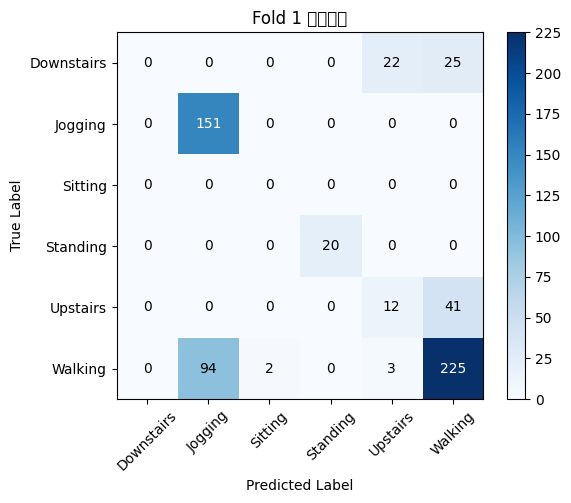


[Fold 2] 혼동행렬 시각화


/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/di

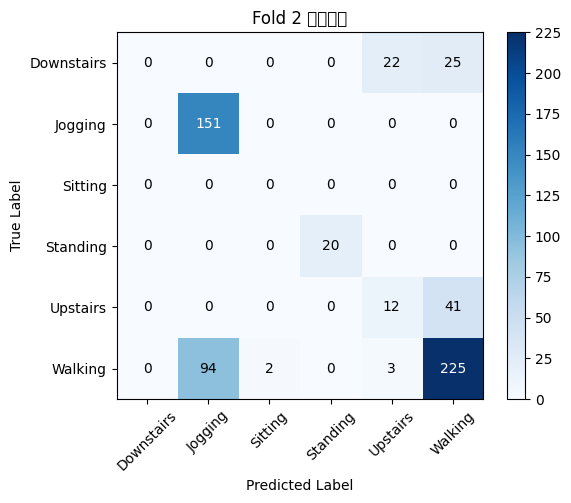


[Fold 3] 혼동행렬 시각화


/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/di

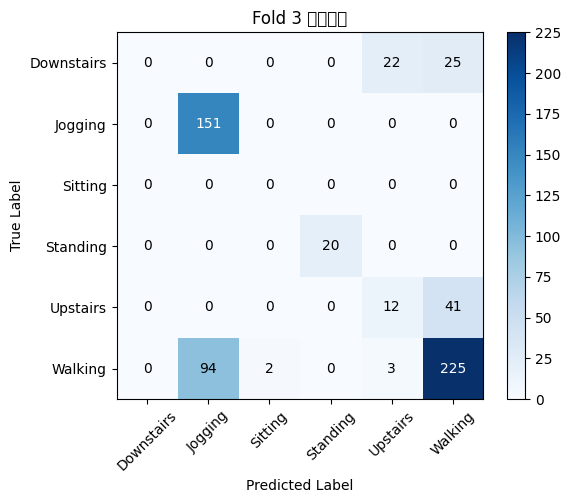


[Fold 4] 혼동행렬 시각화


/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/di

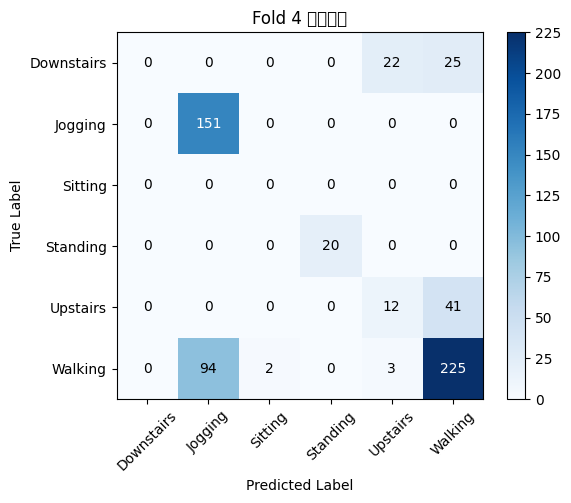


[Fold 5] 혼동행렬 시각화


/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-584140362.py:22: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/di

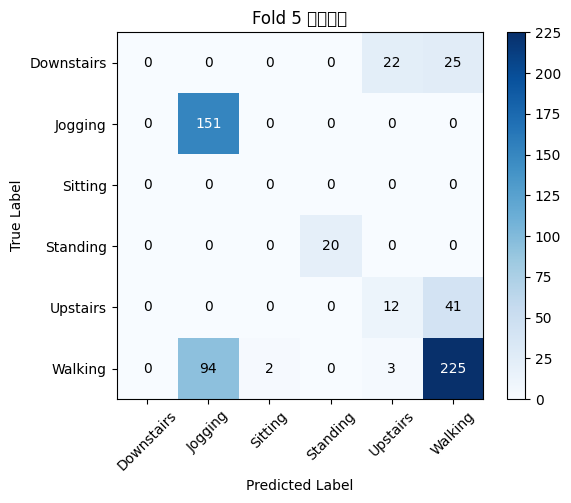

In [13]:
import matplotlib.pyplot as plt

# ===== 혼동행렬 시각화 함수 =====
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ===== fold별 혼동행렬 그리기 =====
for fold_idx, (acc, f1) in enumerate(fold_results, start=1):

    print(f"\n[Fold {fold_idx}] 혼동행렬 시각화")

    plot_confusion_matrix(cm, classes, f"Fold {fold_idx} 혼동행렬")
